By Group 5: 
* Adam Motaouakkil (260956145)
* Frédéric Mheir (260636214)
* Yann Bonzom (260969653)

#Imports

## Matplotlib upgrade
Please run this code block first.
Then, restart and run all

In [1]:
# The line below was necessary for our Google Colab to use the axline function,
# and is used in the ROC curve at the end of the notebook. 
# If an error is thrown at the last section (ROC curve), make sure this line
# is uncommented. It only needs to be ran once.
# Once this is ran successfully, the runtime has to be restarted (Runtime -> Restart and Run all)

!pip install matplotlib --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import Statements

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # For plotting
from IPython.core.debugger import set_trace # To debug

# For data loading
import tarfile
import urllib.request
import shutil
import os.path

# Simpler sklearn functions (like train_test_split) are allowed as per Ed Post #86 - https://edstem.org/us/courses/24117/discussion/1769799
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score # imports for the AUROC

# Task 1.1
import sklearn.datasets
from joblib import Memory

# Task 1.2
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import mutual_info_classif

# For Task 2's model implementations
from sklearn.linear_model import LogisticRegression as sk_LogisticRegression
from sklearn.linear_model import RidgeClassifier as sk_RidgeRegression
from sklearn.linear_model import LassoCV as sk_LassoClassifier
from sklearn.neighbors import KNeighborsClassifier
from seaborn import heatmap

import gc

## Data Loading

In [3]:
url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
compressedFile = "aclImdb_v1.tar.gz"
directory = "aclImdb"


if not os.path.isfile(compressedFile):
  # download if not there already
  urllib.request.urlretrieve(url, "aclImdb_v1.tar.gz") #Download to workspace

if os.path.isdir(directory):
  # delete the directory, so we make sure to start with a fresh one
  shutil.rmtree(directory)

# Extract the tar file
tar = tarfile.open(compressedFile)
tar.extractall(".")
tar.close()

# Task 1

## Task 1.1 - IMDB Dataset

### Creating a Pandas dataframe

In [4]:
imdb_columns = pd.read_csv("aclImdb/imdb.vocab", index_col = False, header=None).T
imdb_columns.columns=imdb_columns.iloc[0]
imdb_columns.drop(0,inplace=True)

mem = Memory("./mycache")

@mem.cache
def getData():
  data = sklearn.datasets.load_svmlight_file("aclImdb/train/labeledBow.feat", dtype='uint8')
  return data[0].toarray(), data[1]

csrmatrix, Y = getData()
imdb_all_features = pd.DataFrame(csrmatrix, columns=imdb_columns.columns)

print(imdb_all_features)

0      the  and   a  of  to  is  it  in  i  this  ...  italian-born  \
0        9    1   4   4   6   4   2   2  4     0  ...             0   
1        7    4   2   2   0   4   1   0  2     2  ...             0   
2        4    4   4   7   2   1   1   1  0     1  ...             0   
3       10    2   2   0   3   2   4   2  0     1  ...             0   
4       13    9   6   4   2   5  10   6  0     2  ...             0   
...    ...  ...  ..  ..  ..  ..  ..  .. ..   ...  ...           ...   
24995   36   16  18  15  11   8   4  11  8     8  ...             0   
24996    4    8   8   3   3   0   6   3  2     3  ...             0   
24997   17    6   7   5   1   2   2   2  2     1  ...             0   
24998   15    8   3   6   0   6   2   3  0     2  ...             0   
24999   10    2   2   1   9   4   4   3  3     0  ...             0   

0      peanut-butter  drug-centred  profanity-laced  sarah-michelle  \
0                  0             0                0               0   
1    

### Words Filtering

First, you may filter out words that appear in less than 1% of the documents and words that
appear in more than 50% of the documents, which are the rare and “stopwords” respectively.
Stopwords are the commonly used words that are not important to our tasks.

In [5]:
occurence = imdb_all_features.astype(bool).sum(axis=0)

In [6]:
size = imdb_all_features.shape[0] # Size = number of text files (which is 25000 according to ReadMe)

one_percent = [] # List storing words < 1 percent
fifty_percent = [] # List storing words > 50 percent

for i in range(0, occurence.shape[0]):
  count = occurence[i]
  word = occurence.index[i]
  if count < size * 0.01:
    one_percent.append(word)
  if count > size * 0.5:
    fifty_percent.append(word)

print("We remove the following words, which appear in less than 1% of documents:")
print(one_percent)
print("")
print("We remove the following words, which appear in more than 50% of documents:")
print(fifty_percent)

imdb = imdb_all_features.drop(columns=one_percent)
imdb = imdb.drop(columns=fifty_percent)
print("")
print("----------------------------------------------------------------------------------")
print("Here is what the dataframe looks like, without those words:")
print("")
print(imdb)

We remove the following words, which appear in less than 1% of documents:
['stewart', 'harry', 'charlie', 'batman', 'kelly', 'vampire', 'henry', 'allen', 'paris', 'bruce', 'jerry', 'arthur', 'page', 'alien', 'noir', 'al', 'christian', 'davis', 'alan', 'ship', 'williams', 'queen', 'soldier', 'stone', 'jackson', 'castle', 'uncle', 'games', 'bond', 'danny', 'scientist', 'fox', 'chinese', 'captain', 'wars', 'andy', 'martial', 'ed', 'nightmare', 'plane', 'heaven', 'humans', 'douglas', 'cgi', 'sky', 'johnny', 'eddie', 'tim', 'witch', 'keaton', 'arts', 'superman', 'devil', 'ford', 'taylor', 'fred', 'adam', 'hitler', 'wedding', 'joan', 'ring', 'prince', 'media', 'machine', 'russian', 'legend', 'jeff', 'suit', 'cops', 'shakespeare', 'religious', 'cage', 'dick', 'grand', 'pilot', 'faith', 'nick', 'price', 'tarzan', 'kevin', 'jesus', 'japan', 'moon', 'freddy', 'river', 'heroine', 'higher', 'dressed', 'whilst', 'friendship', 'teen', 'player', 'kate', 'humanity', 'mike', 'guns', 'officer', 'judge',

As we can see, we are down to only 1744 words.

Let's make an array of all words. This will allow us to keep an index list of the words, which will be useful once our dataframe will be converted to a numpy array.

In [7]:
words_list = [] # Allows to keep track of which zscore corresponds to which word.
for word in imdb.columns:
  words_list.append(word)

print(words_list)

['he', 'his', '!', 'by', 'an', 'who', 'they', 'from', 'so', 'like', 'there', 'her', 'or', 'just', 'about', 'if', 'has', 'out', 'what', '?', 'some', 'good', 'more', 'when', 'she', 'very', 'even', 'my', 'no', 'up', 'time', 'would', 'which', 'only', 'story', 'really', 'their', 'see', 'had', 'can', 'were', 'me', 'we', 'than', 'well', 'much', 'been', 'get', 'people', 'will', 'bad', 'other', 'also', 'into', 'do', 'because', 'great', 'first', 'how', 'him', 'most', "don't", 'its', 'made', 'then', 'them', 'way', 'make', 'could', 'too', 'any', 'after', 'movies', 'think', 'characters', 'character', 'watch', 'films', 'two', 'many', 'seen', 'being', 'acting', 'never', 'plot', 'little', 'where', 'love', 'best', 'life', 'did', 'show', 'know', 'does', 'ever', 'here', 'better', 'man', 'your', 'still', 'end', 'over', 'off', 'these', 'say', 'scene', 'why', 'while', 'scenes', 'such', 'go', 'something', 'should', 'through', 'back', "i'm", 'those', 'watching', 'real', 'though', 'now', "doesn't", 'thing', 'y

In [8]:
# To add the Y_output column:
imdb["Y_Output"] = Y.tolist()
print(imdb)

0      he  his  !  by  an  who  they  from  so  like  ...  portray  length  \
0       0    0  1   0   0    1     0     0   0     0  ...        0       0   
1       0    0  1   0   0    0     0     1   0     3  ...        0       0   
2       0    0  1   0   0    0     0     1   0     0  ...        0       0   
3       0    0  1   0   0    1     0     0   0     1  ...        0       0   
4       0    0  0   1   1    2     0     1   0     1  ...        0       0   
...    ..  ... ..  ..  ..  ...   ...   ...  ..   ...  ...      ...     ...   
24995   5    0  9   3   1    7     3     2   1     0  ...        0       0   
24996   2    2  1   0   0    1     1     1   0     2  ...        0       0   
24997   0    2  0   2   1    2     3     1   0     3  ...        0       0   
24998   0    1  1   0   1    0     0     0   0     0  ...        0       0   
24999   0    0  1   0   1    0     2     0   2     0  ...        0       0   

0      discovered  aware  continues  below  opens  essentially 

### Z-Score

*Second, you need to choose the top D ∈ [100, 1000] features by their absolute z-score as-
sociations with the continuous rating scores (1-10) by using the Simple Linear Regression Hypothesis testing we covered in Module 4.1. In other words, although eventually we will use logistic regression for binary classification on this data, we utilize the continuous rating scores for feature selection. Examine the top features with the most positive z-scores and the top features with most negative z-scores. Do they make sense for calling a movie good and bad, respectively?*

In [9]:
# Standardization

# Here, we standardize each feature (word).
# To do so, we:
#   - take all columns except the last of the imdb DataFrame (X)
#   - convert it to numpy
#   - standardize it (by feature)

# According to https://edstem.org/us/courses/24117/discussion/2012670, 
# no need to standardize output. Just input is necessary, which makes sense.
# This is only for the actual training later – here, we standardize so we can
# make better sense of the data & the z-scores. 

imdb_standardized_X = (imdb.iloc[:,:-1]).to_numpy()
imdb_standardized_X = StandardScaler().fit(imdb_standardized_X).transform(imdb_standardized_X)

imdb_standardized_Y = imdb.loc[:, "Y_Output"].to_numpy().reshape(-1, 1) 
imdb_standardized_Y = StandardScaler().fit(imdb_standardized_Y).transform(imdb_standardized_Y).T[0]

In [10]:
# Formula to calculate the Z-Score using linear regression:
# z-score = x^T y / sqrt(N)
N = imdb.shape[0] # Number of samples
zscores = []  # Array that will contain all zscores (1 for each feature)

for x in imdb_standardized_X.T:

  Zscore = np.dot(x.transpose(), imdb_standardized_Y) / np.sqrt(N) # (x^T * y) / sqrt(N)

  # Add the absolute Z-Score to the list.
  zscores.append(Zscore)

Histogram

(array([0.00015279, 0.00015279, 0.00084033, 0.00297935, 0.01550791,
        0.06355952, 0.04415553, 0.00496559, 0.00061115, 0.00030557]),
 array([-42.9950395 , -35.48925223, -27.98346495, -20.47767768,
        -12.97189041,  -5.46610314,   2.03968413,   9.5454714 ,
         17.05125867,  24.55704594,  32.06283322]),
 <BarContainer object of 10 artists>)

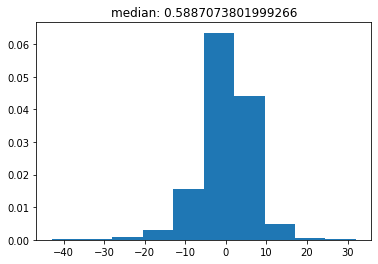

In [11]:
# Hypothesis testing histogram
plt.title(f"median: {np.median(zscores)}")
plt.hist(zscores, density=True)

### Top D Features

Here, we choose D = 100.
We will thus consider in our final IMDB dataset only the D=100 words with the highest absolute Z-Score.


Top 10: ['great', 'wonderful', 'excellent', 'best', 'love', 'amazing', 'loved', 'perfect', 'favorite', 'beautiful']
Bottom 10: ['bad', 'worst', 'waste', 'awful', '?', 'terrible', 'worse', 'no', 'horrible', 'stupid']


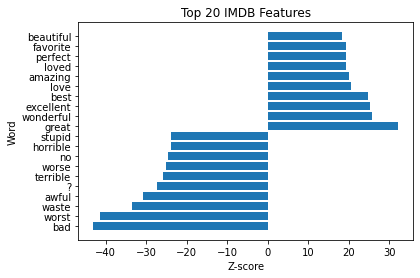

In [12]:
top_10 = []
bottom_10 = []
z_scores_top_20 = []

sorted_word_indices = np.argsort(zscores)
for i in sorted_word_indices[:10]:
  bottom_10.append(words_list[i])
  z_scores_top_20.append(zscores[i])
for i in sorted_word_indices[::-1][:10]:
  top_10.append(words_list[i])
  z_scores_top_20.append(zscores[i])

print(f"Top 10: {top_10}")
print(f"Bottom 10: {bottom_10}")

# matplotlib.pyplot.bar(x, height, width=0.8, bottom=None, *, align='center', data=None, **kwargs)
plt.barh(bottom_10 + top_10, z_scores_top_20)
plt.xlabel("Z-score")
plt.ylabel("Word")
plt.title('Top 20 IMDB Features')
plt.savefig("top_10_zscores.png", bbox_inches='tight', dpi=300)


In [13]:
D = 100

zscores = np.absolute(zscores)
max_list_indices = np.argsort(zscores)[::-1][:D]
max_list_words = []

for i in max_list_indices:
  word = words_list[i]
  max_list_words.append(word)
print(max_list_words)
print("Index of the word '?': ", words_list.index('?'))

['bad', 'worst', 'waste', 'great', 'awful', '?', 'terrible', 'wonderful', 'excellent', 'worse', 'best', 'no', 'horrible', 'stupid', 'boring', 'crap', 'even', 'nothing', 'poor', 'love', 'minutes', 'amazing', 'avoid', 'acting', 'supposed', 'loved', 'perfect', 'favorite', 'ridiculous', 'plot', 'just', 'money', 'poorly', 'beautiful', 'lame', 'superb', 'pointless', "don't", 'script', 'brilliant', 'fantastic', 'highly', 'why', 'pathetic', 'wasted', 'also', 'annoying', 'thing', 'garbage', 'oh', 'mess', 'badly', 'laughable', 'life', 'redeeming', 'very', 'any', 'today', 'both', 'unless', 'performance', 'least', "couldn't", 'beautifully', 'make', 'always', 'well', 'instead', 'cheap', 'if', 'performances', 'save', 'there', 'dull', 'excuse', 'years', 'his', 'could', 'reason', 'wonderfully', 'or', 'perfectly', 'touching', 'outstanding', 'only', 'anything', 'world', 'powerful', 'enjoyed', 'young', 'joke', 'predictable', 'greatest', 'mean', 'bother', 'guy', 'sucks', 'fails', 'moving', 'attempt']
Inde

All words seems to make sense, except the word: '?', which is index 19 in the word_list. 
We have two choices:

1.   Remove this word, as it is a punctuation mark, rather than a word. replace it with the 101th best word, to keep a 100-feature dataset.
2.   Keep the word as it is.

We notice that the word '?' has a high zscore, and a high negative correlation (-0.17). While it may seems surprising, it make sense that negatively rated reviews use question marks, for either sarcasm, disapointment, or interrogation. It is logicial that positive rated values do not use `?`.

In [14]:
# max_list_indices = np.argsort(zscores)[::-1][:D+1]
# max_list_words = []

# for i in max_list_indices:
#   word = words_list[i]
#   if not word == '?':
#     max_list_words.append(word)

# print("Final IMDB dataset list of words:")
# print(max_list_words)
# print("\nSize: ",len(max_list_words))

### Final IMDB DataFrame
Now, lets's make make our final IMDB DataFrame, with only those words.

In [15]:
words_columns = max_list_words
words_columns.append('Y_Output')
imdb = imdb[words_columns] # Make our final dataframe, with 100 words and our Y Output column at the end.
print(imdb)

0      bad  worst  waste  great  awful  ?  terrible  wonderful  excellent  \
0        0      0      0      0      0  0         0          0          0   
1        0      0      0      0      0  0         0          0          0   
2        0      0      0      0      0  0         0          0          0   
3        0      0      0      0      0  2         0          0          0   
4        0      0      0      1      0  0         0          0          0   
...    ...    ...    ...    ...    ... ..       ...        ...        ...   
24995    3      0      0      0      0  5         0          0          0   
24996    1      0      0      0      0  0         0          0          0   
24997    0      0      0      0      0  0         0          0          0   
24998    0      0      0      1      0  0         1          0          1   
24999    0      0      1      0      0  0         0          0          0   

0      worse  ...  predictable  greatest  mean  bother  guy  sucks  fails  

### Analytics

In [16]:
imdb.describe()

,bad,worst,waste,great,awful,?,terrible,wonderful,excellent,worse,...,predictable,greatest,mean,bother,guy,sucks,fails,moving,attempt,Y_Output
count,25000.00000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000,25000.00000,...,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000
mean,0.36664,0.108680,0.058160,0.361320,0.066360,0.643400,0.065480,0.066120,0.08276,0.05852,...,0.034120,0.029800,0.065960,0.015840,0.119280,0.011160,0.024240,0.032120,0.041960,5.477720
std,0.84257,0.383242,0.262869,0.760362,0.300865,1.550514,0.309316,0.285922,0.32273,0.27331,...,0.200393,0.196859,0.287633,0.128022,0.468552,0.122295,0.165812,0.189657,0.223878,3.466477
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.500000
75%,0.00000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000
max,12.00000,10.000000,5.000000,12.000000,6.000000,45.000000,7.000000,4.000000,5.00000,6.00000,...,4.000000,6.000000,4.000000,2.000000,17.000000,7.000000,4.000000,3.000000,5.000000,10.000000


Key observations:
*   The mean score of a review is around 5.5, which is expected, since half of the reviews are negative, and half are positive (no values that are 5 or 6).
*   We can easily notice that each word does not appear in most sentences (75% percentile is 0).



In [17]:
corr = imdb.corr()

imdb_corr = corr["Y_Output"].sort_values()
print(imdb_corr)

0
bad         -0.271925
worst       -0.261959
waste       -0.211661
awful       -0.194440
?           -0.173469
               ...   
best         0.156465
excellent    0.159815
wonderful    0.162297
great        0.202783
Y_Output     1.000000
Name: Y_Output, Length: 101, dtype: float64


From here, we can directly see that the following keywords have a high correlation with negative ratings:


*   bad
*   worst
*   waste
*   awful
*   terrible

The following words have a high correlation with a positive rating:
*   best
*   excellent
*   wonderful
*   great

From a logical perspective, those keywords make a lot of sense, as they are words commonly associated with negative and positive content, respectively.


### Final datasets (train & validation)

Split into train & test sets, standardization of inputs & conversion to numpy. No need to standardize outputs as that does not matter.

In [18]:
y_binary = imdb.loc[:, "Y_Output"].to_numpy()
y_binary = np.around(y_binary / 10)
X_imdb_train, X_imdb_val, y_imdb_train, y_imdb_val = train_test_split(
    imdb.iloc[:,:-1].to_numpy(), y_binary, test_size = 0.2, random_state=1, shuffle=True)

X_imdb_train_total = imdb.iloc[:,:-1].to_numpy()
y_imdb_train_total = imdb.loc[:, "Y_Output"].to_numpy()
# For testing with predicting the rating directly
X_imdb_train_rating, X_imdb_val_rating, y_imdb_train_rating, y_imdb_val_rating = train_test_split(
    X_imdb_train_total, y_imdb_train_total, test_size = 0.2, random_state=1, shuffle=True)

# Standardization is done separately to ensure no info leakage (since we'd use mean & std of everything)
X_imdb_train = StandardScaler().fit(X_imdb_train).transform(X_imdb_train)
X_imdb_val = StandardScaler().fit(X_imdb_val).transform(X_imdb_val)
X_imdb_test = StandardScaler().fit(X_imdb_val).transform(X_imdb_val)

# Standardize X_imdb_train_total
X_imdb_train_total = StandardScaler().fit(X_imdb_train_total).transform(X_imdb_train_total)


In [19]:
print(X_imdb_train.shape)
print(y_imdb_train.shape)
print(X_imdb_val.shape)
print(y_imdb_val.shape)

(20000, 100)
(20000,)
(5000, 100)
(5000,)


### Final datasets (testing)

We load the data in the same manner as the train/validate sections only we drop the last four columns because they are not included in the .feat file for testing.

In [20]:
from joblib import Memory
mem = Memory("./mycache")

import sklearn.datasets
@mem.cache
def getData():
  data = sklearn.datasets.load_svmlight_file("aclImdb/test/labeledBow.feat", dtype='uint8')
  return data[0].toarray(), data[1]

csrmatrix, Y = getData()

In [21]:
# Drop the last 4 columns from the sparse matrix to fit with the labeledBow.
test_imdb_columns = imdb_columns.drop(imdb_columns.columns[[89523, 89524, 89525, 89526]], axis=1)

test_imdb = pd.DataFrame(data=csrmatrix, columns=test_imdb_columns.columns)
test_imdb = test_imdb[[col for col in words_columns if col != "Y_Output"]]
X_imdb_test = StandardScaler().fit(test_imdb).transform(test_imdb)

y_imdb_test = np.around(Y / 10)

In [22]:
print(X_imdb_test.shape)
print(y_imdb_test.shape)

(25000, 100)
(25000,)


### Clear variables

In [23]:
del imdb_columns
del csrmatrix
del Y
del imdb_all_features
del imdb
del imdb_standardized_X
del imdb_standardized_Y
del max_list_indices
del max_list_words

gc.collect()

5137

## Task 1.2 - 20 news groups

### Get data from sklearn

In [24]:
# Pick our categories
categories = ['comp.graphics', 'rec.sport.hockey', 'sci.med', 'soc.religion.christian']
# Pull data for just those categories
data = fetch_20newsgroups(subset='train', remove=(['headers','footers','quotes']), categories=categories)

### Vectorize data 

In [25]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data.data)

### Create a X input dataframe

In [26]:
npX = np.array(X.toarray())
news = pd.DataFrame(data = npX, columns = vectorizer.get_feature_names_out())
print(news)

      00  000  0000  000005102000  000100255pixel  00014  0007  000usd  0010  \
0      0    0     0             0               0      0     0       0     0   
1      0    0     0             0               0      0     0       0     0   
2      0    0     0             0               0      0     0       0     0   
3      0    0     0             0               0      0     0       0     0   
4      0    0     0             0               0      0     0       0     0   
...   ..  ...   ...           ...             ...    ...   ...     ...   ...   
2372   0    0     0             0               0      0     0       0     0   
2373   0    0     0             0               0      0     0       0     0   
2374   0    0     0             0               0      0     0       0     0   
2375   0    0     0             0               0      0     0       0     0   
2376   0    0     0             0               0      0     0       0     0   

      001200201pixel  ...  zubkoff  zub

### Words Filtering

In [27]:
occurence = news.astype(bool).sum(axis=0)

In [28]:
size = news.shape[0] # Size = number of text files (which is 25000 according to ReadMe)

one_percent = [] # List storing words < 1 percent
fifty_percent = [] # List storing words > 50 percent

for i in range(0, occurence.shape[0]):
  count = occurence[i]
  word = occurence.index[i]
  if count < size * 0.01:
    one_percent.append(word)
  if count > size * 0.5:
    fifty_percent.append(word)

print("We remove the following words, which appear in less than 1% of documents:")
print(one_percent)
print("")
print("We remove the following words, which appear in more than 50% of documents:")
print(fifty_percent)

news = news.drop(columns=one_percent)
news = news.drop(columns=fifty_percent)
print("")
print("----------------------------------------------------------------------------------")
print("Here is what the dataframe looks like, without those words:")
print("")
print(news)

We remove the following words, which appear in less than 1% of documents:
['0000', '000005102000', '000100255pixel', '00014', '0007', '000usd', '0010', '001200201pixel', '0014', '00196', '0028', '0033', '0038', '004021809', '0049', '005', '00500', '008561', '0094', '00am', '00index', '00pm', '01', '0100', '011', '013', '013846', '013939', '014', '01720', '01752', '0179', '01821', '01830', '0184', '01852', '01854', '01890', '0199', '01a', '02', '020', '0200', '020637', '021', '02115', '02118', '02139', '02154', '02160', '02173', '0223', '0235', '0278', '02908', '03', '03051', '0306', '0318', '0330', '0358', '036', '037', '0372', '03756', '038', '04', '040', '040286', '04046', '0410', '042', '0435', '0458', '0483', '04g', '05', '050', '0502', '051', '0511', '053', '05401', '05402', '05446', '055', '059', '06', '06320', '0649', '065', '06510', '0656', '0666', '068', '07', '072', '0729', '07410', '0752', '07653', '077', '08', '0804', '081', '084', '08786', '089', '08934', '09', '0900', '09

### One Hot Encoding of Y

In [29]:
# Labels for all documents
news_labels = data.target # this is 1 column, with values 0,1,2,3
ohe = OneHotEncoder()

# Create dataframe with 1 column per category
news_labels = ohe.fit_transform(news_labels.reshape(-1, 1)).toarray()
labels_df = pd.DataFrame(data = news_labels, columns=categories)
print(labels_df)

      comp.graphics  rec.sport.hockey  sci.med  soc.religion.christian
0               0.0               0.0      1.0                     0.0
1               0.0               0.0      0.0                     1.0
2               1.0               0.0      0.0                     0.0
3               0.0               0.0      1.0                     0.0
4               1.0               0.0      0.0                     0.0
...             ...               ...      ...                     ...
2372            1.0               0.0      0.0                     0.0
2373            0.0               1.0      0.0                     0.0
2374            0.0               0.0      1.0                     0.0
2375            0.0               1.0      0.0                     0.0
2376            0.0               0.0      0.0                     1.0

[2377 rows x 4 columns]


### Top D Features

In [30]:
# CURRENTLY COMMENTED OUT to improve performance, since each run results in the same final_words list
# but this section with mutual info takes forever to compute

# D = 15
# final_words = []
# for c in categories:
#   res = mutual_info_classif(news, labels_df[c])
#   res = np.argsort(res)[::-1][:D]
#   for i in res:
#     word = news.columns[i]
#     if word not in final_words:
#       final_words.append(word)
# print(final_words)

In [31]:
final_words = ['graphics', 'files', 'image', 'file', 'people', 'he', '3d', 'video', 'who', 'while', 'was', 'algorithms', '19', 'ftp', 'program', 'team', 'game', 'hockey', 'play', 'season', 'league', 'games', 'nhl', 'playoffs', 'teams', 'cup', '37', 'win', 'players', 'detroit', 'gordon', 'dsl', 'geb', 'doctor', 'medicine', 'intellect', 'n3jxp', 'patients', 'pitt', 'diet', 'skepticism', 'chastity', 'cadre', 'treatment', 'banks', 'god', 'bible', 'jesus', 'christian', 'christ', 'christians', 'faith', 'not', 'church', 'we', 'christianity', 'us', 'our', 'believe']

### Final News DataFrame

In [32]:
news = news[final_words]
print(news)

      graphics  files  image  file  people  he  3d  video  who  while  ...  \
0            0      0      0     0       0   0   0      0    0      0  ...   
1            0      0      0     0       0   0   0      0    1      0  ...   
2            0      0      0     0       0   0   0      0    0      0  ...   
3            0      0      0     0       0   0   0      0    0      0  ...   
4            0      0      0     0       0   0   0      0    0      0  ...   
...        ...    ...    ...   ...     ...  ..  ..    ...  ...    ...  ...   
2372         1      0      0     0       0   0   0      0    0      0  ...   
2373         0      0      0     0       0   0   0      0    0      0  ...   
2374         0      0      0     0       0   0   0      0    1      0  ...   
2375         0      0      0     0       0   0   0      0    0      0  ...   
2376         0      0      0     0       0   0   0      0    2      1  ...   

      christ  christians  faith  not  church  we  christianity 

### Analytics

In [33]:
news.describe()

,graphics,files,image,file,people,he,3d,video,who,while,...,christ,christians,faith,not,church,we,christianity,us,our,believe
count,2377.000000,2377.000000,2377.000000,2377.000000,2377.000000,2377.000000,2377.000000,2377.000000,2377.000000,2377.000000,...,2377.000000,2377.000000,2377.000000,2377.000000,2377.000000,2377.000000,2377.000000,2377.000000,2377.00000,2377.000000
mean,0.175011,0.096340,0.213294,0.122423,0.339083,0.875053,0.060160,0.039546,0.494741,0.113168,...,0.119058,0.101809,0.109382,1.291965,0.143879,0.658814,0.058056,0.203618,0.21708,0.172066
std,2.367463,1.109899,3.534633,1.933378,0.995930,3.040682,1.003864,0.351932,1.273960,0.458991,...,0.773429,0.507255,0.697386,2.953439,0.998061,2.099613,0.395678,0.868803,0.98601,0.668755
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
max,104.000000,38.000000,125.000000,85.000000,12.000000,47.000000,43.000000,9.000000,17.000000,9.000000,...,21.000000,7.000000,12.000000,58.000000,18.000000,34.000000,10.000000,19.000000,28.00000,13.000000


### Final datasets (train & validation)

In [34]:
# Have y be binary
y_binary = labels_df

# Convert to float
news = news.astype(float)

# Convert to numpy
X_news_train_total = news.to_numpy()
y_news_train_total = y_binary.to_numpy()

X_news_train, X_news_val, y_news_train, y_news_val = train_test_split(
    X_news_train_total, y_news_train_total, test_size = 0.2, random_state=1, shuffle=True)

# Standardization is done separately to ensure no info leakage (since we'd use mean & std of everything)
X_news_train = StandardScaler().fit(X_news_train).transform(X_news_train)
X_news_val = StandardScaler().fit(X_news_val).transform(X_news_val)
X_news_train_total = StandardScaler().fit(X_news_train_total).transform(X_news_train_total)

In [35]:
print(X_news_train)

[[ 0.68712606 -0.08511587 -0.06906815 ... -0.23027013 -0.21427532
  -0.25806961]
 [-0.07341347 -0.08511587 -0.06906815 ...  0.84791587 -0.21427532
   4.18836835]
 [-0.07341347 -0.08511587 -0.06906815 ...  0.84791587  2.68148809
   1.22407638]
 ...
 [-0.07341347 -0.08511587 -0.06906815 ...  0.84791587  0.75097915
   1.22407638]
 [-0.07341347 -0.08511587 -0.06906815 ... -0.23027013 -0.21427532
  -0.25806961]
 [-0.07341347 -0.08511587 -0.06906815 ... -0.23027013 -0.21427532
  -0.25806961]]


### Final datasets (testing)

In [36]:
# Load data
test_data = fetch_20newsgroups(subset='test', remove=(['headers','footers','quotes']), categories=categories)

# Vectorize
test_vectorizer = CountVectorizer()
test_X = test_vectorizer.fit_transform(test_data.data)

# To dataframe
test_npX = np.array(test_X.toarray())
test_news = pd.DataFrame(data = test_npX, columns = test_vectorizer.get_feature_names_out())

# Keep only the words we're looking for (as per https://edstem.org/us/courses/24117/discussion/2036953)
# As not all words necessarily appear in testing set, create empty columns so we have same format
for word in final_words:
    if word not in test_news.columns:
        test_news[word] = 0
test_news = test_news[final_words]

# One hot encoding of y
test_news_labels = test_data.target
test_ohe = OneHotEncoder()
test_news_labels = test_ohe.fit_transform(test_news_labels.reshape(-1, 1)).toarray()
test_labels_df = pd.DataFrame(data = test_news_labels, columns=categories)

# Final renaming
X_news_test = test_news
y_news_test = test_labels_df

# Type conversion to float
X_news_test = X_news_test.astype(float) # Added astype(float)

#Conversion to numpy
X_news_test = X_news_test.to_numpy()
y_news_test = y_news_test.to_numpy()

# Standardization
X_news_test = StandardScaler().fit(X_news_test).transform(X_news_test)

In [37]:
print(X_news_test)
print(y_news_test)

[[-0.08680857 -0.08181422 -0.08205453 ... -0.20402968 -0.21123451
  -0.23071567]
 [-0.08680857 -0.08181422 -0.08205453 ... -0.20402968 -0.21123451
  -0.23071567]
 [-0.08680857 -0.08181422 -0.08205453 ... -0.20402968 -0.21123451
  -0.23071567]
 ...
 [-0.08680857 -0.08181422 -0.08205453 ... -0.20402968 -0.21123451
  -0.23071567]
 [-0.08680857 -0.08181422 -0.08205453 ... -0.20402968 -0.21123451
  -0.23071567]
 [-0.08680857 -0.08181422 -0.08205453 ... -0.20402968  0.73009786
  -0.23071567]]
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]


### Clear variables

In [38]:
del data
del vectorizer
del X
del npX
del news
del occurence
del ohe
del news_labels
del labels_df
del test_data
del test_vectorizer
del test_X
del test_npX
del test_news
del test_ohe
del test_news_labels
del test_labels_df

gc.collect()

44

# Task 2: Implement Logistic and Multiclass Classifiers

## Logistic Regression Classifier
Source: class Colab code at https://colab.research.google.com/github/yueliyl/comp551-notebooks/blob/master/LogisticRegression.ipynb#scrollTo=F94XLCBvfYCg 

In [39]:
logistic = lambda z: 1./ (1 + np.exp(-z))

class LogisticRegression:
    
    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients 
        self.max_iters = max_iters                    #maximum number of iteration of gradient descent
        self.verbose = verbose
        self.gradients = []

    def gradient(self, x, y):
        N,D = x.shape
        yh = logistic(np.dot(x, self.w))    # predictions  size N
        grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
        return grad
        
    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf 
        t = 0
        # the code snippet below is for gradient descent
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g = self.gradient(x, y)
            self.w = self.w - self.learning_rate * g 
            t += 1
            self.gradients.append(np.linalg.norm(g))
        
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))            #predict output
        return yh

    def evaluate_auroc(self, y_test_prob, y_test):
      auroc = roc_auc_score(y_test, y_test_prob)

      self.residual = np.sum(np.abs(y_test - y_test_prob))/y_test.shape[0]

      return auroc

    # y_test_prob is the result we get upon calling fit & then predict
    # We pass all data so that we can train different models for comparison
    def evaluate_with_auc(self, y_test_prob, X_train, X_test, y_train, y_test):
        models = [KNeighborsClassifier(), sk_LogisticRegression()]
        perf = {}

        fpr, tpr, _ = roc_curve(y_test, y_test_prob)
        auroc = roc_auc_score(y_test, y_test_prob)
        perf["LogisticRegression (ours)"] = {'fpr':fpr, 'tpr':tpr, 'auroc':auroc}

        for model in models:
            fit = model.fit(X_train, y_train)
            y_test_prob = fit.predict_proba(X_test)[:,1]
            fpr, tpr, _ = roc_curve(y_test, y_test_prob)
            auroc = roc_auc_score(y_test, y_test_prob)
            if type(model).__name__ == "LogisticRegression":
                perf["LogisticRegression (sklearn)"] = {'fpr':fpr,'tpr':tpr,'auroc':auroc}
            else:
                perf[type(model).__name__] = {'fpr':fpr,'tpr':tpr,'auroc':auroc}

        plt.clf()
        i = 0
        for model_name, model_perf in perf.items():
            plt.plot(model_perf['fpr'], model_perf['tpr'],label=model_name)
            plt.text(0.4, i+0.1, model_name + ': AUC = '+ str(round(model_perf['auroc'],2)))
            i += 0.1
        plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title('ROC in IMBD Review Classification')
        plt.legend(bbox_to_anchor=(1.04, 0.5), loc="upper left")
        # plt.show()
        plt.savefig("roc_curve.png", bbox_inches='tight', dpi=300)
        # plt.close()

    # Performs gradient check with small perturbation
    def check_grad(self, X, y):

      diffTooLarge = False
      diff = np.zeros(X.shape[1])

      for x in range(0, X.shape[1]):
        w = np.random.randn(1)
        w0 = w
        epsilon = np.random.randn(1)[0] * 1e-5
        w1 = w0 + epsilon
        w2 = w0 - epsilon
        a1 = w1*x
        a2 = w2*x
        ce1 = np.sum(y * np.log1p(np.exp(-a1)) + (1-y) * np.log1p(np.exp(a1)))
        ce2 = np.sum(y * np.log1p(np.exp(-a2)) + (1-y) * np.log1p(np.exp(a2)))
        dw_num = (ce1 - ce2)/(2*epsilon) # approximated gradient

        yh = 1/(1+np.exp(-x * w))
        dw_cal = np.sum((yh - y) * x) # hand calculated gradient

        # print(dw_cal)
        # print(dw_num)
        # print((dw_cal - dw_num)**2/(dw_cal + dw_num)**2)
        if (dw_cal + dw_num != 0):
          diff[x] = ((dw_cal - dw_num)**2/(dw_cal + dw_num)**2)
        else:
          diff[x] = 0

        if (diff[x] > 10**(-8) ):
          diffTooLarge = True

      if not diffTooLarge:
        print("Small perturbation gradient test is good.")
      else:
        print("Small perturbation gradient test failed.")
      print(diff.sum())
      # print("Total diff: ", diff.sum())
      # return diff.sum()

    def monitor_cross_entropy(self, X, y):
      lr = 0.001
      niter = 500
      ce_all = np.zeros(niter)
      w = np.random.randn(1)
      w0 = w
      x = X[:,0]

      for i in range(niter):
          a = w * x
          ce_all[i] = np.sum(y * np.log1p(np.exp(-a)) + (1-y) * np.log1p(np.exp(a))) # cross-entropy
          y_hat = 1 / (1 + np.exp(-a))
          dw = np.sum((y_hat - y) * x)
          w = w - lr * dw

      plt.clf()
      plt.figure(figsize=((16/9)*3.6,3.6))
      plt.plot(ce_all)
      plt.ylabel("Cross entropy")
      plt.xlabel("iteration")
      # plt.title(f"True w={w_true}; Estimated w={round(w.astype(float)[0],2)}")
      plt.title(f"Estimated w={round(w.astype(float)[0],2)}")
      # plt.show()
      plt.savefig('ce_iteration.png', bbox_inches="tight", dpi=300)


## Multiclass Logistic Regression Classifier
Source: class Colab code at https://colab.research.google.com/github/yueliyl/comp551-notebooks/blob/master/MulticlassLogistic.ipynb#scrollTo=F-M84Ug6ZaTF 

Adaptation was required in the ce implementation, replacing np.log with np.log1p for improved accuracy as many numerical errors were encountered when testing out different hyperparamters. 

In [40]:
class Multinomial_logistic:
    def __init__(self, nFeatures, nClasses):
        self.W = np.random.rand(nFeatures, nClasses)

    def grad(self, X, y):
        return np.matmul(X.transpose(), self.predict(X) - y)

    def ce(self, X, y):
        # return -np.sum(y * np.log1p(self.predict(X)))
        return -np.sum(y * np.log(self.predict(X)))
    
    # modify it to add stopping criteria (what can you think of?)
    def fit(self, X, y, X_valid=None, y_valid=None, lr=0.005, niter=100, print_iter=False):
        losses_train = np.zeros(niter)
        losses_valid = np.zeros(niter)
        for i in range(niter):
            self.W = self.W - lr * self.grad(X, y)
            loss_train = self.ce(X, y)
            losses_train[i] = loss_train
            # The print statements allow us to "monitor the cross-entropy as a function of iteration"
            if X_valid is not None and y_valid is not None:
                loss_valid = self.ce(X_valid, y_valid)
                losses_valid[i] = loss_valid
                if print_iter:
                  print(f"iter {i}: {loss_train:.3f}; {loss_valid:.3f}")
            else:
                print(f"iter {i}: {loss_train:.3f}")
        return losses_train, losses_valid

    def predict(self, X):
        # y_pred = np.exp(np.matmul(X, self.W))
        # return y_pred / y_pred.sum(axis=1).reshape(X.shape[0], 1)
        # Modification, to solve NaN:
        # See https://edstem.org/us/courses/24117/discussion/2013670
        XW = np.matmul(X, self.W)
        y_pred = np.exp(XW - np.max(XW))
        return y_pred / y_pred.sum(axis=1).reshape(X.shape[0], 1)

    def evaluate(self, y, y_pred):
        accuracy = sum(y_pred.argmax(axis=1) == y.argmax(axis=1))
        accuracy = accuracy / y.shape[0]
        return accuracy

        # Can use this to evaluate on different sets
        # train_accuracy = evaluate(mlr.predict(X_train), y_train)
        # valid_accuracy = evaluate(mlr.predict(X_valid), y_valid)
        # test_accuracy = evaluate(mlr.predict(X_test), y_test)
        # print(train_accuracy)
        # print(valid_accuracy)
        # print(test_accuracy)

    def evaluate_against_knn(self, X_train, X_test, y_train, y_test, y_pred):
        knn = KNeighborsClassifier()
        knn.fit(X_train, y_train)
        y_pred_knn = knn.predict(X_test)
        accuracy_knn = sum(y_pred_knn == y_test)  / y_test.shape[0]
        accuracy_multi_logistic = self.evaluate(y_test, y_pred)
        print(f"Accuracy of KNN: {accuracy_knn}")
        print(f"Accuracy of Multinomial Logistic Regression: {accuracy_multi_logistic}")
        return [accuracy_knn, accuracy_multi_logistic]

    # Run this after fitting the model to visualize the weights
    # Set plot_as_softmax to True to clearly see the largest weights
    def weight_heatmap(self, words, categories):
        W_hat = self.W
        print(W_hat)
        words_per_section = int(len(words) / 4)
        scores = []
        words_list = []
        for i in range(4):
            section = W_hat[i * words_per_section: (i + 1) * words_per_section]
            section = [j[i] for j in section]
            section = np.argsort(section)
            section = section[-5:]
            print(section)
            for value in section:
                scores.append(W_hat[i * words_per_section + value])
                words_list.append(words[i * words_per_section + value])
        hmp = heatmap(scores, cmap='RdBu_r', center=0, yticklabels=words_list, xticklabels=categories)
        fig = hmp.get_figure()
        fig.savefig("W_hat.png")

    # Performs gradient check with small perturbation
    def check_grad(self, X, y):
        N, C = y.shape
        D = X.shape[1]
        diff = np.zeros((D, C))
        W = self.W.copy()

        # Added a boolean, to check if we have a diff too large
        diffTooLarge = False

        for i in range(D):
            for j in range(C):
                epsilon = np.zeros((D, C))
                epsilon[i, j] = np.random.rand() * 1e-4
                self.W = self.W + epsilon
                J1 = self.ce(X, y)
                self.W = W
                self.W = self.W - epsilon
                J2 = self.ce(X, y)
                self.W = W
                numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
                derived_grad = self.grad(X, y)[i, j]
                diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \
                             np.square(derived_grad + numeric_grad).sum()
                
        # The diff must be small (e.g. 10^-8)
        # print(diff)
        if diff.sum() > (10**(-8)):
          diffTooLarge = True

        if not diffTooLarge:
          print("Small perturbation gradient test is good (less than 10^-8)")
        else:
          print("Small perturbation gradient test failed (difference of more than 10^-8)")
        print("Difference between gradient and estimated gradient: ", diff.sum())
        # return diff.sum()

    def monitor_cross_entropy(self, X, y):
      lr = 0.001
      niter = 500
      ce_all = np.zeros(niter)
      w = np.random.randn(1)
      w0 = w
      x = X[:,0]

      for i in range(niter):
          a = w * x
          ce_all[i] = np.sum(y * np.log1p(np.exp(-a)) + (1-y) * np.log1p(np.exp(a))) # cross-entropy
          y_hat = 1 / (1 + np.exp(-a))
          dw = np.sum((y_hat - y) * x)
          w = w - lr * dw

      plt.clf()
      plt.figure(figsize=((16/9)*3.6,3.6))
      plt.plot(ce_all)
      plt.ylabel("Cross entropy")
      plt.xlabel("iteration")
      # plt.title(f"True w={w_true}; Estimated w={round(w.astype(float)[0],2)}")
      plt.title(f"Estimated w={round(w.astype(float)[0],2)}")
      # plt.show()
      plt.savefig('ce_iteration.png', bbox_inches="tight", dpi=300)

## Task 2.1

### Check Gradient - Logistic

In [41]:
model = LogisticRegression(verbose=False, add_bias=False)

model.check_grad(X_imdb_train, y_imdb_train)

Small perturbation gradient test is good.
4.832075411421906e-16


### Monitor Cross-Entropy - Logistic

<Figure size 432x288 with 0 Axes>

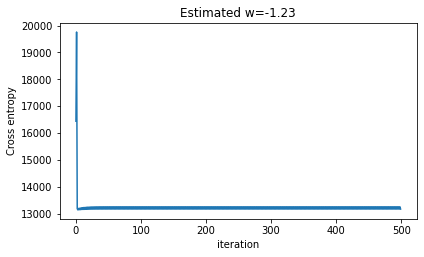

In [42]:
model = LogisticRegression(verbose=False, add_bias=False)

model.monitor_cross_entropy(X_imdb_train.astype(np.float128), y_imdb_train)

### Check Gradient - Multiclass

In [43]:
D = X_news_train.shape[1]
C = y_news_train.shape[1]

mlr = Multinomial_logistic(D, C)

mlr.check_grad(X_news_train, y_news_train)

Small perturbation gradient test is good (less than 10^-8)
Difference between gradient and estimated gradient:  2.4592762422224822e-14


### Monitor Cross-Entropy - Multiclass

<Figure size 432x288 with 0 Axes>

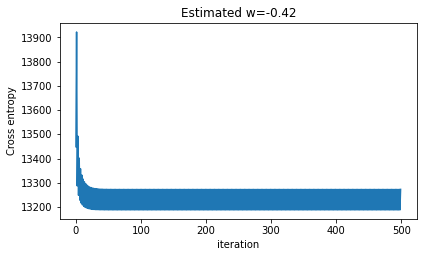

In [44]:
D = X_news_train.shape[1]
C = y_news_train.shape[1]

multi_test = Multinomial_logistic(D, C)
multi_test.monitor_cross_entropy(X_imdb_train.astype(np.float128), y_imdb_train)

# Task 3: Run Experiments

## Logistic Regression Tests

### Basic Test

terminated after 1000 iterations, with norm of the gradient equal to 3.380076569722379
the weight found: [-77.3989158  -77.00276514 -61.87315265  61.62215792 -56.82466991
 -48.25936451 -47.4217013   48.93544467  48.31463456 -45.1886731
  48.16073462 -41.91593951 -43.98313673 -42.58108319 -40.93667879
 -40.41717269 -35.5377548  -36.48915327 -36.88509963  39.77770732
 -35.6950701   38.8109759  -36.73782766 -34.02821467 -34.09687972
  36.61533791  37.18529028  37.30360758 -33.69276816 -32.26317246
 -30.10258512 -33.09628333 -34.09812205  35.05008171 -33.02420936
  34.54211121 -32.33560819 -28.60305555 -31.12546449  33.49379269
  32.82449817  32.05034914 -27.96268227 -30.20790187 -29.77079669
  32.58627034 -29.28789555 -26.73878435 -29.95336645 -28.0210462
 -28.86692154 -28.96934878 -29.10932038  30.26487798 -28.41126579
  30.40953374 -24.5430103   29.40765241  28.9813179  -26.03041916
  27.66949484 -24.53551182 -25.62616502  28.08997137 -23.70171639
  28.01809141  28.92473901 -24.73194843

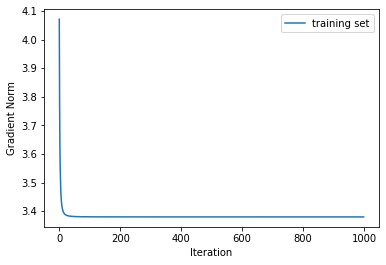

In [45]:
X_train, y_train = X_imdb_train_total, y_imdb_train_total
model = LogisticRegression(verbose=True, add_bias=False, max_iters=1000)
model.fit(X_train.astype(np.float128), y_train)
y_test_pred = model.predict(X_imdb_test.astype(np.float128))
prob = model.evaluate_with_auc(y_test_pred, X_imdb_train, X_imdb_test, y_imdb_train, y_imdb_test)
final_auroc = model.evaluate_auroc(y_test_pred, y_imdb_test)

plt.clf()
plt.plot(model.gradients, label='training set')
plt.xlabel("Iteration")
plt.ylabel("Gradient Norm")
plt.legend()
plt.savefig("gradient_norm.png", bbox_inches="tight", dpi=300)

### Top 10 Words and Bottom 10 Words
Now we select the top 10 and bottom 10 words based on weights.

Top 10: ['great', 'wonderful', 'excellent', 'best', 'love', 'amazing', 'favorite', 'perfect', 'loved', 'beautiful']
Bottom 10: ['bad', 'worst', 'waste', 'awful', '?', 'terrible', 'worse', 'horrible', 'stupid', 'no']


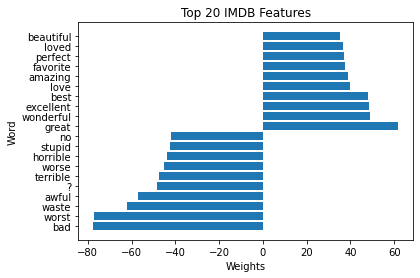

In [46]:
top_10_w = []
bottom_10_w = []
weights_top_20 = []

model_weights = model.w
sorted_weights = np.argsort(model_weights)

for i in sorted_weights[:10]:
  bottom_10_w.append(words_columns[i])
  weights_top_20.append(model_weights[i])

for i in sorted_weights[::-1][:10]:
  top_10_w.append(words_columns[i])
  weights_top_20.append(model_weights[i])

print(f"Top 10: {top_10_w}")
print(f"Bottom 10: {bottom_10_w}")

plt.barh(bottom_10_w + top_10_w, weights_top_20)
plt.xlabel("Weights")
plt.ylabel("Word")
plt.title('Top 20 IMDB Features')
plt.savefig("top_10_weights.png", bbox_inches='tight', dpi=300)

### Performance vs. training size


Logistic - Percentage 0.2: 0.8445015808
Logistic - Percentage 0.4: 0.8407098912
Logistic - Percentage 0.6: 0.8442039872
Logistic - Percentage 0.8: 0.8412573087999999
Logistic - Percentage 1: 0.8424291007999999

KNN - Percentage 0.2: 0.3717379936
KNN - Percentage 0.4: 0.36210650880000006
KNN - Percentage 0.6: 0.3565060832
KNN - Percentage 0.8: 0.35219500800000003
KNN - Percentage 1: 0.345216976



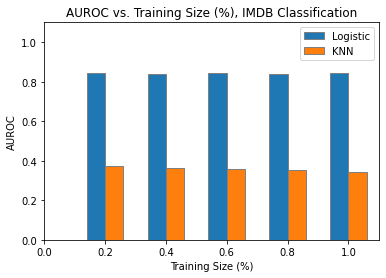

<Figure size 432x288 with 0 Axes>

In [47]:
# Logistic
# X_imdb_train_total & y_imdb_train_total contain all training data
# X_imdb_train_total = X_imdb_train
# y_imdb_train_total = y_imdb_train

performances = []
percentages = [.2, .4, .6, .8, 1]
for percentage in percentages:
  if percentage != 1:
    X_train, _, y_train, _ = train_test_split(X_imdb_train_total, y_imdb_train_total, test_size = 1 - percentage, random_state=1, shuffle=True)
  else:
    X_train, y_train = X_imdb_train_total, y_imdb_train_total
  model = LogisticRegression(verbose=False, add_bias=False, max_iters=1000)
  model.fit(X_train.astype(np.float128), y_train)
  y_test_pred = model.predict(X_imdb_test.astype(np.float128))
  auroc = model.evaluate_auroc(y_test_pred, y_imdb_test)
  performances.append(auroc)
  print(f"Logistic - Percentage {percentage}: {auroc}")

print()

# KNN
performancesKnn = []
percentagesKnn = [.2, .4, .6, .8, 1]
for percentage in percentagesKnn:
  if percentage != 1:
    X_train, _, y_train, _ = train_test_split(X_imdb_train_total, y_imdb_train_total, test_size = 1 - percentage, random_state=1, shuffle=True)
  else:
    X_train, y_train = X_imdb_train_total, y_imdb_train_total
  knn = KNeighborsClassifier()
  knn.fit(X_train.astype(np.float128), y_train)
  y_test_prob = knn.predict_proba(X_imdb_test)[:,1]
  auroc = roc_auc_score(y_imdb_test, y_test_prob)
  performancesKnn.append(auroc)
  print(f"KNN - Percentage {percentage}: {auroc}")

print()

# Bar Plot
percentages = np.array(percentages)
plt.clf()
plt.bar(percentages - 0.03, performances, width = 0.06, edgecolor='grey', label = 'Logistic')
plt.bar(percentages + 0.03, performancesKnn, width = 0.06, edgecolor='grey', label = 'KNN')
plt.xlim([0.0, 1.1])
plt.ylim([0, 1.1])
plt.xlabel("Training Size (%)")
plt.ylabel("AUROC")
plt.title('AUROC vs. Training Size (%), IMDB Classification')
plt.legend()
plt.show()
plt.savefig("auroc_vs_training_imdb.png", bbox_inches='tight', dpi=300)
# plt.close()

### Varying Learning Rates

A higher learning rate is better for faster convergence and thus lower training time. However, the smaller values do give higher auroc values, indicating a better fit. Max_iters was fixed to just 1000 to see how very low values might not converge/require more iterations to converge. 

In [48]:
X_train, y_train = X_imdb_train_total, y_imdb_train_total
learning_rates = [0.05, 0.01, 0.005, 0.001, 0.0001, 0.00001]
learn_res = []
performances = []
for lr in learning_rates:
  model = LogisticRegression(verbose=True, add_bias=False, learning_rate=lr, max_iters=1000)
  model.fit(X_train.astype(np.float128), y_train)
  y_test_pred = model.predict(X_imdb_test.astype(np.float128))
  final_auroc = model.evaluate_auroc(y_test_pred, y_imdb_test)
  learn_res.append(model.residual)
  performances.append(final_auroc)
  print(f"Learning rate {lr}: {final_auroc} (auroc)")

terminated after 1000 iterations, with norm of the gradient equal to 3.3800860423377768
the weight found: [-38.72490081 -38.52659013 -30.95410277  30.82587542 -28.43072313
 -24.14271384 -23.72560714  24.4731679   24.16300968 -22.61125791
  24.08973332 -20.96803545 -22.00163997 -21.30532831 -20.47836158
 -20.22042431 -17.78225566 -18.26098958 -18.45707341  19.89491287
 -17.86085484  19.41124794 -18.37781261 -17.02324665 -17.05783218
  18.31770841  18.59884478  18.65254571 -16.85839172 -16.14912136
 -15.06589151 -16.55920277 -17.05591738  17.5287695  -16.52217164
  17.27395381 -16.17538882 -14.31233927 -15.57401304  16.75073457
  16.41365889  16.03258473 -13.99321224 -15.1123458  -14.89638303
  16.2980639  -14.65153438 -13.3806596  -14.98713833 -14.02079506
 -14.44658969 -14.48892681 -14.56048388  15.13732884 -14.21417103
  15.21024141 -12.28456356  14.71620436  14.49252489 -13.02628286
  13.83740745 -12.28163679 -12.82320715  14.0484651  -11.86292797
  14.01203287  14.46531616 -12.37723

AUROC Plot

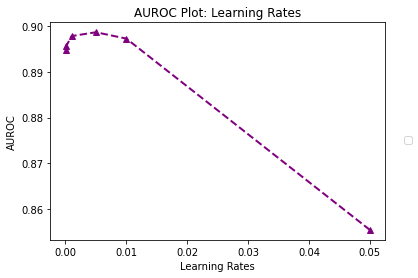

In [49]:
plt.clf()
plt.plot(learning_rates, performances, marker="^", color="purple", lw=2, linestyle="--")
plt.xlabel("Learning Rates")
plt.ylabel("AUROC")
plt.title('AUROC Plot: Learning Rates')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="upper left")
# plt.show()
plt.savefig("auroc_learn.png", bbox_inches='tight', dpi=300)
# plt.close()

### Varying Max Iteration

For the default learning rate of 0.1, we converge at value of 1192, so we only really need that many iterations. Setting the max_iters too low clearly gives inferior performance since the model does not converge. 

In [50]:
max_iterations = [1, 100, 1000, 1500]
performances = []
for iters in max_iterations:
  model = LogisticRegression(verbose=True, add_bias=False, max_iters=iters)
  model.fit(X_train.astype(np.float128), y_train)
  y_test_pred = model.predict(X_imdb_test.astype(np.float128))
  final_auroc = model.evaluate_auroc(y_test_pred, y_imdb_test)
  performances.append(final_auroc)
  print(f"Max Iteration {iters}: {final_auroc} (auroc)")

terminated after 1 iterations, with norm of the gradient equal to 4.071053409254601
the weight found: [-0.09426013 -0.09080567 -0.07337037  0.07029292 -0.06740076 -0.06013128
 -0.05665558  0.05625882  0.05539839 -0.05508732  0.05423706 -0.05401157
 -0.05233576 -0.05221872 -0.04920203 -0.04892945 -0.04656713 -0.04638953
 -0.04505851  0.045042   -0.04488678  0.04383183 -0.04381922 -0.04312094
 -0.04241121  0.04213224  0.04209585  0.04209556 -0.04141664 -0.04131106
 -0.04110805 -0.04092955 -0.04091179  0.04022292 -0.04021587  0.03956333
 -0.03886589 -0.03882456 -0.03864911  0.0384121   0.03732791  0.03685332
 -0.03682244 -0.03626496 -0.03606137  0.0357177  -0.0357125  -0.03562348
 -0.03549923 -0.03515918 -0.03506748 -0.03499745 -0.03490397  0.03409817
 -0.0340328   0.03382933 -0.03371684  0.03353212  0.03310128 -0.03238996
  0.03224808 -0.03221055 -0.03215375  0.03212721 -0.03195993  0.03183174
  0.03157399 -0.03132586 -0.03095141 -0.03070065  0.0305637  -0.03047591
 -0.03039986 -0.030141

AUROC Plot

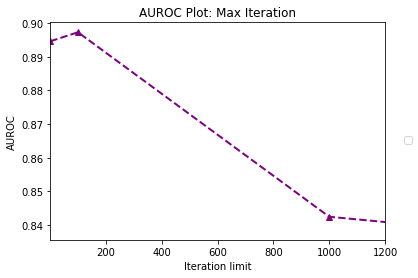

In [51]:
plt.clf()
plt.plot(max_iterations, performances, marker="^", color="purple", lw=2, linestyle="--")
plt.xlim([1, 1200])
plt.xlabel("Iteration limit")
plt.ylabel("AUROC")
plt.title('AUROC Plot: Max Iteration')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="upper left")
# plt.show()
plt.savefig("auroc_max.png", bbox_inches='tight', dpi=300)
# plt.close()

### Varying Stopping Criteria

Here we modify the tolerance value and investigate how the weights behave for different values.

In [52]:
tol_values = [1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4]
tol_perf = []
for tol in tol_values:
  model = LogisticRegression(verbose=True, add_bias=False, epsilon=tol, max_iters=1000)
  model.fit(X_train.astype(np.float128), y_train)
  y_test_pred = model.predict(X_imdb_test.astype(np.float128))
  final_auroc = model.evaluate_auroc(y_test_pred, y_imdb_test)
  tol_perf.append(final_auroc)
  print(f"Tolerance {tol}: {final_auroc} (auroc)")

terminated after 1 iterations, with norm of the gradient equal to 4.071053409254601
the weight found: [-0.09426013 -0.09080567 -0.07337037  0.07029292 -0.06740076 -0.06013128
 -0.05665558  0.05625882  0.05539839 -0.05508732  0.05423706 -0.05401157
 -0.05233576 -0.05221872 -0.04920203 -0.04892945 -0.04656713 -0.04638953
 -0.04505851  0.045042   -0.04488678  0.04383183 -0.04381922 -0.04312094
 -0.04241121  0.04213224  0.04209585  0.04209556 -0.04141664 -0.04131106
 -0.04110805 -0.04092955 -0.04091179  0.04022292 -0.04021587  0.03956333
 -0.03886589 -0.03882456 -0.03864911  0.0384121   0.03732791  0.03685332
 -0.03682244 -0.03626496 -0.03606137  0.0357177  -0.0357125  -0.03562348
 -0.03549923 -0.03515918 -0.03506748 -0.03499745 -0.03490397  0.03409817
 -0.0340328   0.03382933 -0.03371684  0.03353212  0.03310128 -0.03238996
  0.03224808 -0.03221055 -0.03215375  0.03212721 -0.03195993  0.03183174
  0.03157399 -0.03132586 -0.03095141 -0.03070065  0.0305637  -0.03047591
 -0.03039986 -0.030141

AUROC Plot

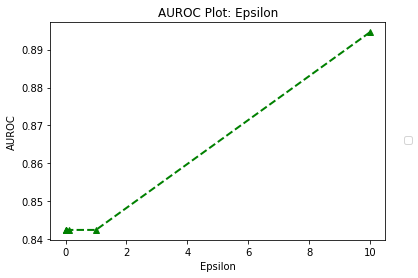

In [53]:
plt.clf()
plt.plot(tol_values, tol_perf, marker="^", color="green", lw=2, linestyle="--")
plt.xlabel("Epsilon")
plt.ylabel("AUROC")
plt.title('AUROC Plot: Epsilon')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="upper left")
# plt.show()
plt.savefig("auroc_eps.png", bbox_inches='tight', dpi=300)
# plt.close()

### Ridge Regression Comparison
Now we investigate how the ridge regression performs compared to logistic regression.

In [54]:
model = LogisticRegression(verbose=False, add_bias=False)
model.fit(X_imdb_train, y_imdb_train)
y_pred_log = model.predict(X_imdb_test)

for i in range(len(y_pred_log)):
  y_pred_log[i] = round(y_pred_log[i])

ridge = sk_RidgeRegression(alpha=2.0)
y_pred_ridge = ridge.fit(X_imdb_train, y_imdb_train).predict(X_imdb_test)
accuracy_ridge = sum(y_pred_ridge == y_imdb_test)  / y_imdb_test.shape[0]
accuracy_logistic = sum(y_pred_log == y_imdb_test) / y_imdb_test.shape[0]
print(f"Accuracy of Ridge Regression: {accuracy_ridge}")
print(f"Accuracy of Logistic Regression: {accuracy_logistic}")

Accuracy of Ridge Regression: 0.82524
Accuracy of Logistic Regression: 0.82552


Ridge regression does not differ greatly from the logistic regression that we have implemented. Ridge regression works best with data with a high degree of multi-colinearity between data points.

### LASSO Regression Comparison
We investigate how LASSO performs compared to logistic regression.

In [55]:
lasso = sk_LassoClassifier(cv=2)
y_pred_lasso = lasso.fit(X_imdb_train, y_imdb_train).predict(X_imdb_test)
for i in range(len(y_pred_lasso)):
  y_pred_lasso[i] = round(y_pred_lasso[i])
accuracy_lasso = sum(y_pred_lasso == y_imdb_test)  / y_imdb_test.shape[0]
print(f"Accuracy of Lasso Regression: {accuracy_lasso}")
print(f"Accuracy of Logistic Regression: {accuracy_logistic}")

Accuracy of Lasso Regression: 0.81676
Accuracy of Logistic Regression: 0.82552


The accuracy of LASSO is lower than the baseline logistic regression that we've implemented. I don't know why that is the case however.

## Multiclass Logistic Regression Tests

### Basic Test

0.7617043661230931
0.792016806722689
0.7256637168141593


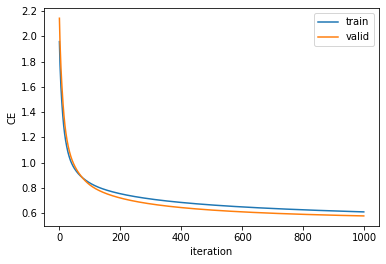

In [56]:
D = X_news_train.shape[1]
C = y_news_train.shape[1]

mlr = Multinomial_logistic(D, C)

ce_news_train, ce_news_valid = mlr.fit(X_news_train, y_news_train, X_news_val, y_news_val, 0.00005, niter=1000, print_iter=False)

plt.clf()
plt.plot(ce_news_train/X_news_train.shape[0], label='train')
plt.plot(ce_news_valid/X_news_val.shape[0], label='valid')
plt.xlabel("iteration")
plt.ylabel("CE")
plt.legend()
plt.savefig("training_ce.png", bbox_inches="tight", dpi=300)

train_accuracy = mlr.evaluate(mlr.predict(X_news_train), y_news_train)
valid_accuracy = mlr.evaluate(mlr.predict(X_news_val), y_news_val)
y_news_test_pred = mlr.predict(X_news_test)
final_test_accuracy = mlr.evaluate(y_news_test_pred, y_news_test)

print(train_accuracy)
print(valid_accuracy)
print(final_test_accuracy)

### Heatmap

[[ 1.53961063  0.3640815   0.11748602  0.34209356]
 [ 1.65020486  0.26551362  0.47328166  0.26593558]
 [ 1.48957521  0.12707205 -0.04987246  0.44866099]
 [ 1.22117775  0.58139991  0.07573349  0.47605317]
 [ 0.50364936  0.57821287  1.20334973  1.07784357]
 [-0.22467364  0.78425269 -0.17005645  0.33077247]
 [ 1.69243402 -0.05452408  0.56990428  0.44906694]
 [ 0.88916477  0.07445306  0.09390472 -0.06035317]
 [-0.2068473   0.42728054  0.44052117  0.77935572]
 [ 0.05123896  0.16375697  0.39706397  0.11465354]
 [ 0.68957595  0.93548067  0.85756979  0.81284158]
 [ 0.83230446  0.26259725  0.55497572  0.26460529]
 [ 0.10600465  0.51628433  0.10017812  0.56997736]
 [ 0.99307477  0.41315838  0.11312912 -0.16579635]
 [ 0.79491234 -0.26762692  0.55531162  0.00919206]
 [ 0.28016456  1.64242355 -0.23905083 -0.32491071]
 [ 0.41813059  1.97224783  0.25452311  0.35280954]
 [ 0.68811061  1.03576244  0.27946282  0.26190441]
 [ 0.64441978  1.47318675  0.01600295  0.2447975 ]
 [ 0.4744556   1.19162391  0.61

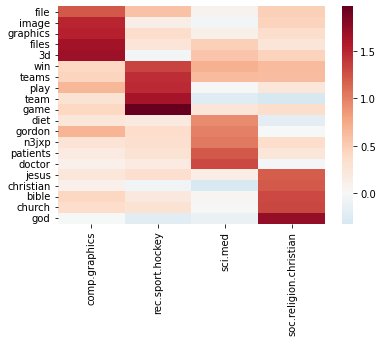

In [57]:
mlr.weight_heatmap(final_words, categories)

### Multiclass Logistic vs. KNN

KNN outperforms multiclass logistic regression by a fair bit: .72 vs .87. 

In [58]:
knn_acc, _ = mlr.evaluate_against_knn(X_news_train, X_news_test, y_news_train, y_news_test, y_news_test_pred)
print(f"KNN average accuracy: {sum(knn_acc) / len(knn_acc)}")

Accuracy of KNN: [0.86346397 0.91908976 0.79835651 0.88242731]
Accuracy of Multinomial Logistic Regression: 0.7256637168141593
KNN average accuracy: 0.865834386852086


### Performance vs. training size

More data, better results. The results do vary with every run of the code below due to randomization of the training set. However, generally, the score increases with the quantity of data. 

Multiclass - Percentage 0.2: 0.656763590391909
Multiclass - Percentage 0.4: 0.6700379266750948
Multiclass - Percentage 0.6: 0.7123893805309734
Multiclass - Percentage 0.8: 0.7060682680151706
Multiclass - Percentage 1: 0.729456384323641
KNN - Percentage 0.2: 0.8487673830594185
KNN - Percentage 0.4: 0.8634639696586599
KNN - Percentage 0.6: 0.8663084702907712
KNN - Percentage 0.8: 0.8694690265486726
KNN - Percentage 1: 0.8554045512010113



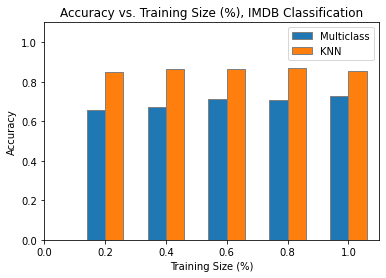

<Figure size 432x288 with 0 Axes>

In [59]:
# X_news_train_total & y_news_train_total contain all data
performances = []
percentages = [.2, .4, .6, .8, 1]
for percentage in percentages:
  if percentage != 1:
    X_train, _, y_train, _ = train_test_split(X_news_train_total, y_news_train_total, test_size = 1 - percentage, random_state=1, shuffle=True)
  else:
    X_train, y_train = X_news_train_total, y_news_train_total
  mlr = Multinomial_logistic(D, C)
  mlr.fit(X_train, y_train, X_news_val, y_news_val, 0.00005, niter=1000)
  test_accuracy = mlr.evaluate(mlr.predict(X_news_test), y_news_test)
  performances.append(test_accuracy)
  print(f"Multiclass - Percentage {percentage}: {test_accuracy}")

# KNN
performancesKnn = []
percentagesKnn = [.2, .4, .6, .8, 1]
for percentage in percentagesKnn:
  if percentage != 1:
    X_train, _, y_train, _ = train_test_split(X_news_train_total, y_news_train_total, test_size = 1 - percentage, random_state=1, shuffle=True)
  else:
    X_train, y_train = X_news_train_total, y_news_train_total
  knn = KNeighborsClassifier()
  knn.fit(X_train, y_train)
  y_pred_knn = knn.predict(X_news_test)
  accuracy_knn = sum(y_pred_knn == y_news_test)  / y_news_test.shape[0]
  # y_test_prob = np.array(knn.predict_proba(X_news_test))[:,:,1].T
  # fpr, tpr, _ = roc_curve(y_news_test, y_test_prob)
  # auroc = roc_auc_score(y_news_test, y_test_prob)
  avg_accuracy_knn = sum(accuracy_knn)/len(accuracy_knn)
  performancesKnn.append(avg_accuracy_knn)
  print(f"KNN - Percentage {percentage}: {avg_accuracy_knn}")

print()

# Bar Plot
percentages = np.array(percentages)
plt.clf()
plt.bar(percentages - 0.03, performances, width = 0.06, edgecolor='grey', label = 'Multiclass')
plt.bar(percentages + 0.03, performancesKnn, width = 0.06, edgecolor='grey', label = 'KNN')
plt.xlim([0.0, 1.1])
plt.ylim([0, 1.1])
plt.xlabel("Training Size (%)")
plt.ylabel("Accuracy")
plt.title('Accuracy vs. Training Size (%), IMDB Classification')
plt.legend()
plt.show()
plt.savefig("accuracy_vs_training_news.png", bbox_inches='tight', dpi=300)
# plt.close()

### Varying Learning Rates

If lr too high (0.0001 or 0.00009 in the tests below), we get a division by 0 (at times, not always) leading to an error & thus low accuracy. From trial & error, valus around 0.00008 give the best testing accuracy in repeat trials and consistenly work out correctly. 

In [60]:
learning_rates = [0.0001, 0.000095, 0.00009, 0.00008, 0.00005, 0.00004, 0.00001]
learn_res = []
performances = []
for lr in learning_rates:
  mlr = Multinomial_logistic(D, C)
  mlr.fit(X_news_train.astype(np.float128), y_news_train, X_news_val.astype(np.float128), y_news_val, lr=lr, niter=1000)
  test_accuracy = mlr.evaluate(mlr.predict(X_news_test.astype(np.float128)), y_news_test)
  learn_res.append(mlr.ce(X_news_train.astype(np.float128), y_news_train))
  performances.append(test_accuracy)
  print(f"Learning rate {lr}: {test_accuracy}")

Learning rate 0.0001: 0.7250316055625791
Learning rate 9.5e-05: 0.7364096080910241
Learning rate 9e-05: 0.7313527180783818
Learning rate 8e-05: 0.7155499367888748
Learning rate 5e-05: 0.729456384323641
Learning rate 4e-05: 0.7155499367888748
Learning rate 1e-05: 0.6396965865992414


Convergence Plot on Learning Rates

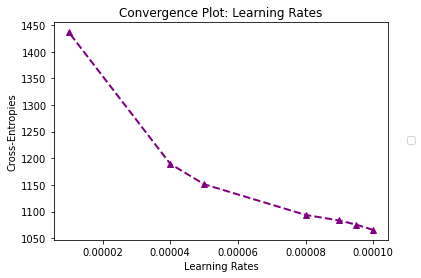

In [61]:
plt.clf()
plt.plot(learning_rates, learn_res, marker="^", color="purple", lw=2, linestyle="--")
plt.xlabel("Learning Rates")
plt.ylabel("Cross-Entropies")
plt.title('Convergence Plot: Learning Rates')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="upper left")
# plt.show()
plt.savefig("conv_news_lr.png", bbox_inches='tight', dpi=300)
# plt.close()

### Varying Max Iteration

We pick the best lr determined from the previous step. We again encounter numerical issues, especially for a high number of iterations as the change in certain values becomes so low in gradient descent that it causes errors. 

Using a higher lr leads to faster training in fewer iterations, as is evident below. 1000 iterations seems like a suitable choice given that the model does not obviously improve past that. 

In [62]:
niterations = [500, 800, 1000, 1200, 1500, 1800, 2000, 2300, 2500]
cross_entropies = []
performances = []
for niter in niterations:
  mlr = Multinomial_logistic(D, C)
  mlr.fit(X_news_train.astype(np.float128), y_news_train, X_news_val.astype(np.float128), y_news_val, lr=0.00008, niter=niter)
  test_accuracy = mlr.evaluate(mlr.predict(X_news_test.astype(np.float128)), y_news_test)
  cross_entropies.append(mlr.ce(X_news_train.astype(np.float128), y_news_train))
  performances.append(test_accuracy)
  print(f"Max Iteration {niter}: {test_accuracy}")

Max Iteration 500: 0.6991150442477876
Max Iteration 800: 0.7231352718078382
Max Iteration 1000: 0.7364096080910241
Max Iteration 1200: 0.7414664981036663
Max Iteration 1500: 0.7262958280657396
Max Iteration 1800: 0.7243994943109987
Max Iteration 2000: 0.7275600505689002
Max Iteration 2300: 0.7218710493046776
Max Iteration 2500: 0.7231352718078382


Convergence Plot on Max Iteration

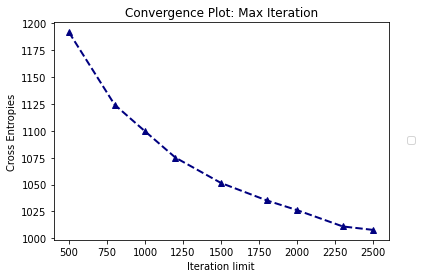

In [63]:
plt.clf()
plt.plot(niterations, cross_entropies, marker="^", color="navy", lw=2, linestyle="--")
plt.xlabel("Iteration limit")
plt.ylabel("Cross Entropies")
plt.title('Convergence Plot: Max Iteration')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="upper left")
# plt.show()
plt.savefig("conv_news_iterations.png", bbox_inches='tight', dpi=300)
# plt.close()